In [1]:
import backtrader as bt
import yfinance as yf
import pyfolio as pf
import pandas as pd

/opt/miniconda3/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
class MOMStrategy(bt.Strategy):

    def __init__(self):
        # Initialize Momentum indicator
        self.mom = bt.indicators.Momentum(self.data.close, period=1)  # Momentum for one period (current closing price - previous closing price)
        self.order = None

    def next(self):
        if self.order:  # If there is an open order, do nothing
            return

        # Buy if current closing price is higher than previous period's closing price
        if not self.position and self.data.close[0] > self.data.close[-1]:
            cash = self.broker.get_cash()
            price = self.data.close[0]
            shares_to_buy = cash // price
            if shares_to_buy > 0:            
                self.log('Create Buy, %.2f' % self.data.close[0])
                self.order = self.buy(size=shares_to_buy)

        # Sell if current closing price is lower than previous period's closing price
        elif self.position and self.data.close[0] < self.data.close[-1]:
            self.log('Create Sell, %.2f' % self.data.close[0])
            self.order = self.sell(size=self.position.size)

    def log(self, txt):
        dt = self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status == order.Completed:
            if order.isbuy():
                self.log(
                "BUY EXECUTED (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            else:
                self.log(
                "SELL EXECUTED (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order is canceled/margin/rejected")
        self.order = None

In [3]:
def test_strategy(strategy_class, ticker, start_date, end_date, starting_cash=100000):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class)
    
    # Download data and store it in a variable
    yf_data = yf.download(ticker, start=start_date, end=end_date, multi_level_index=False)
    data = bt.feeds.PandasData(dataname=yf_data)
    cerebro.adddata(data)
    
    cerebro.broker.setcash(starting_cash)
    cerebro.broker.setcommission(commission=0.0002)
    
    # Add observer to track portfolio value
    cerebro.addobserver(bt.observers.Value)
    
    # Add analyzer to track returns
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    
    print('Initial portfolio value: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    print('Final portfolio value: %.2f' % cerebro.broker.getvalue())
    
    strat = results[0]
    
    # Get data from PyFolio analyzer
    portfolio_value = strat.analyzers.pyfolio.get_pf_items()
    returns, positions, transactions, gross_lev = portfolio_value

    # Get portfolio values
    portfolio_values = strat.observers.value.get(size=len(strat))
    
    # Create DataFrame with dates and portfolio values
    df_portfolio = pd.DataFrame({
        'Date': yf_data.index,
        'Value': portfolio_values
    })    
    
    # Use pyfolio to generate report
    pf.create_simple_tear_sheet(returns)

    return df_portfolio

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Initial portfolio value: 100000.00
2024-08-02, Create Buy, 219.12
2024-08-05, BUY EXECUTED (Price: 198.42, Value: 90480.94, Commission 18.10)
2024-08-05, Create Sell, 208.57
2024-08-06, SELL EXECUTED (Price: 204.61, Value: 90480.94, Commission 18.66)
2024-08-07, Create Buy, 209.12
2024-08-08, Order is canceled/margin/rejected
2024-08-08, Create Buy, 212.60
2024-08-09, BUY EXECUTED (Price: 211.39, Value: 102101.15, Commission 20.42)
2024-08-19, Create Sell, 225.39
2024-08-20, SELL EXECUTED (Price: 225.27, Value: 102101.15, Commission 21.76)
2024-08-20, Create Buy, 226.01
2024-08-21, BUY EXECUTED (Price: 226.02, Value: 109394.92, Commission 21.88)
2024-08-21, Create Sell, 225.90
2024-08-22, SELL EXECUTED (Price: 227.29, Value: 109394.92, Commission 22.00)
2024-08-23, Create Buy, 226.34
2024-08-26, Order is canceled/margin/rejected
2024-08-26, Create Buy, 226.68
2024-08-27, BUY EXECUTED (Price: 225.50, Value: 109369.29, Commission 21.87)
2024-08-28, Create Sell, 225.99
2024-08-29, SELL EX


/opt/miniconda3/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '42.178%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2024-08-01
End date,2025-02-27
Total months,6
,Backtest
Annual return,42.178%
Cumulative returns,22.274%
Annual volatility,15.183%
Sharpe ratio,2.39
Calmar ratio,5.65
Stability,0.56
Max drawdown,-7.464%


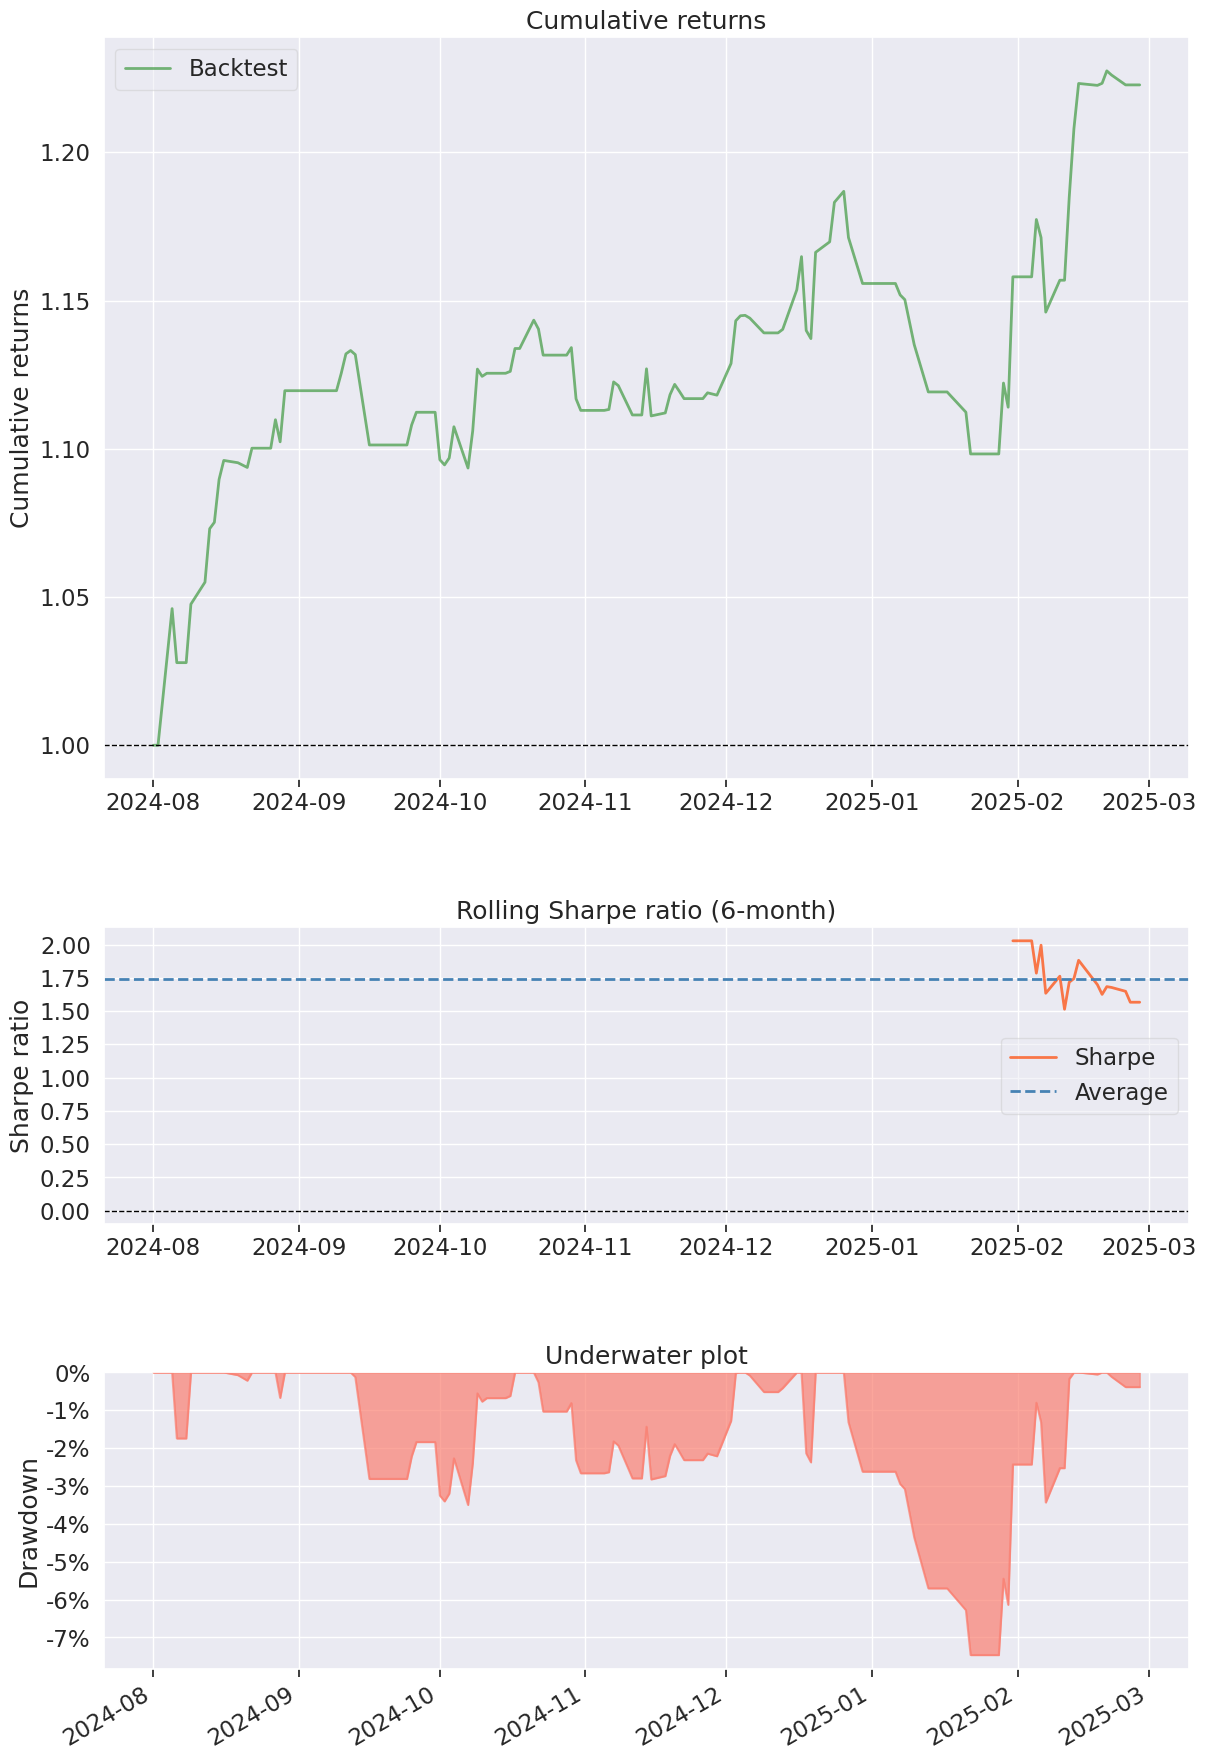

In [4]:
results = test_strategy(MOMStrategy, 'AAPL', '2024-08-01', '2025-02-28')

In [5]:
import pickle

# Za df_account_value_sac
with open('results/aapl_momentum_strategy.pkl', 'wb') as f:
    pickle.dump(results, f)